In [1]:
import EEGAnalysis as ea
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import h5py
import os, re

from tqdm import tqdm
from sklearn.decomposition import PCA

In [2]:
_freq = 2000
ROI = (-3, 3)
# frange = np.logspace(np.log10(10), np.log10(150), 40)
frange = np.logspace(np.log10(1), np.log10(150), 40)
zbase = (-2,-1)
tspec = np.linspace(ROI[0], ROI[1], int(_freq)*(ROI[1]-ROI[0]))


nyq = _freq / 2.0
width = 5.0 / nyq
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = signal.kaiserord(ripple_db, width)

taps = signal.firwin(N, [50/nyq, 80/nyq],window=('kaiser', beta),pass_zero=False)

# _filted = signal.filtfilt(taps, 1, _data)
# _hilbert_pwr = np.abs(signal.hilbert(_filted))

In [3]:
dm = ea.DataManager('/media/STORAGE/EEG/Data')
patient = dm.get_patient('zhouchen')

_behavior = pd.read_csv('../Step_3_Behavior_Stat/zhouchen-behavior-final.csv', dtype={'date':'str'})
check_behavior_prediction = lambda x,y,z: _behavior.time[(_behavior.paradigm == x) & (_behavior['date'] == y)].values < z
_behavior[(_behavior.paradigm=='1-10') & (_behavior.date=='180901')].head(3)


,date,paradigm,time,trial
60,180901,1-10,0.32,1
61,180901,1-10,-0.36,2
62,180901,1-10,0.12,3


---
# Preview

In [10]:
%%time

chidx = 8
_data_list = patient.load_isplit(chidx)


_m = patient.get_marker(file='180827-1', paradigm='1-10')
_prediction = check_behavior_prediction('1-10', '180827', 0)

_filtered = signal.hilbert(signal.filtfilt(taps, 1, _data_list['180827-1']['value']))

_epoch = ea.create_1d_epoch_bymarker(_filtered, _m, ROI, int(_freq))

_pwr = ea.decomposition.dwt_power(_epoch.reshape((20, 1, -1)), _freq, baseline=(zbase[0]-ROI[0], zbase[1]-ROI[0]))

CPU times: user 32.1 s, sys: 227 ms, total: 32.3 s
Wall time: 22.8 s


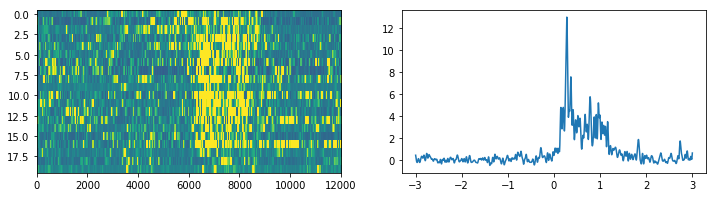

In [11]:
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
plt.imshow(_pwr, aspect='auto')
plt.clim((-3,3))

plt.subplot(1,2,2)
plt.plot(tspec, np.mean(_pwr, 0))

plt.show()

In [72]:
pca = PCA(n_components=2).fit_transform(_pwr)

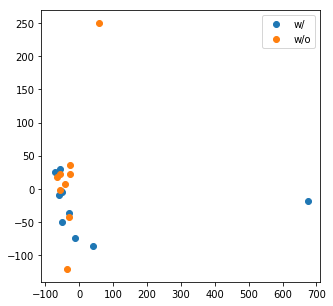

In [77]:
plt.figure(figsize=(5,5))
plt.scatter(pca[_prediction, 0], pca[_prediction, 1], label='w/')
plt.scatter(pca[~_prediction, 0], pca[~_prediction, 1], label='w/o')
plt.legend()
plt.show()

---
# groups

In [89]:
%%time

_batch_power = np.zeros((0, 12000))
_batch_prediction = np.zeros((0,), dtype='bool')
pbar = tqdm(total=110*7)

for chidx in range(110):
    _data_list = patient.load_isplit(chidx)
    for _idate in _data_list.keys():
        if _idate[-1] != '1':
            continue

        _m = patient.get_marker(file=_idate, paradigm='1-10')
        _prediction = check_behavior_prediction('1-10', _idate[:6], 0)

        _filtered = signal.hilbert(signal.filtfilt(taps, 1, _data_list['180901-1']['value']))

        _epoch = ea.create_1d_epoch_bymarker(_filtered, _m, ROI, int(_freq))

        _pwr = ea.decomposition.dwt_power(_epoch.reshape((20, 1, -1)), _freq, baseline=(zbase[0]-ROI[0], zbase[1]-ROI[0]))

        _batch_prediction = np.hstack((_batch_prediction, _prediction))
        _batch_power = np.vstack((_batch_power, _pwr))
        pbar.update(1)
pbar.close()

100%|██████████| 770/770 [09:26<00:00,  1.25it/s]

CPU times: user 1h 23min 30s, sys: 6min 21s, total: 1h 29min 52s
Wall time: 9min 26s


In [90]:
pca = PCA(n_components=2).fit_transform(_batch_power)

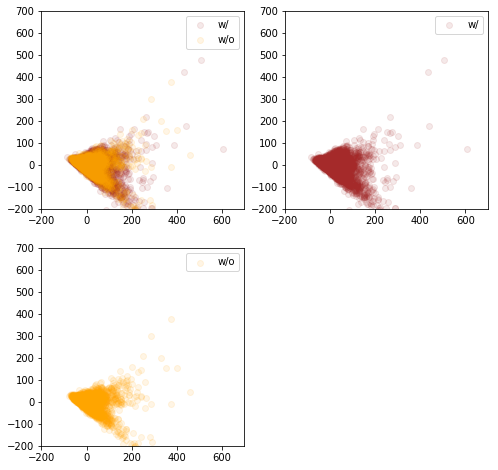

In [96]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.scatter(pca[_batch_prediction, 0], pca[_batch_prediction, 1], c='brown', label='w/', alpha=0.1)
plt.scatter(pca[~_batch_prediction, 0], pca[~_batch_prediction, 1], c='orange', label='w/o', alpha=0.1)
plt.xlim((-200, 700))
plt.ylim((-200, 700))
plt.legend()

plt.subplot(2,2,2)
plt.scatter(pca[_batch_prediction, 0], pca[_batch_prediction, 1], c='brown', label='w/', alpha=0.1)
# plt.scatter(pca[~_batch_prediction, 0], pca[~_batch_prediction, 1], label='w/o', alpha=0.1)
plt.xlim((-200, 700))
plt.ylim((-200, 700))
plt.legend()

plt.subplot(2,2,3)
# plt.scatter(pca[_batch_prediction, 0], pca[_batch_prediction, 1], label='w/', alpha=0.1)
plt.scatter(pca[~_batch_prediction, 0], pca[~_batch_prediction, 1], c='orange', label='w/o', alpha=0.1)
plt.xlim((-200, 700))
plt.ylim((-200, 700))
plt.legend()

plt.show()

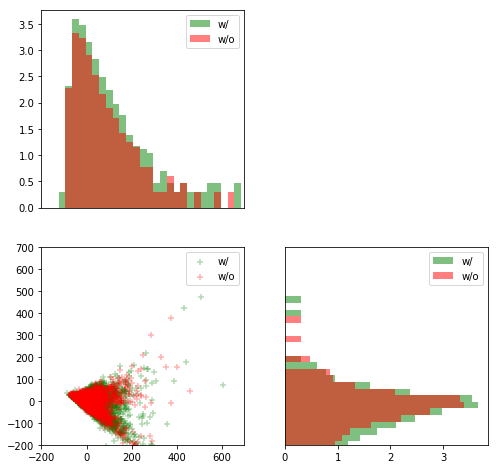

In [104]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
hi_w, x = np.histogram(pca[_batch_prediction,0], range=(-200, 700), bins=30)
hi_wo, x = np.histogram(pca[~_batch_prediction,0], range=(-200,700), bins=30)
plt.bar(x[:-1]+1, np.log10(hi_w+1), alpha=0.5, width=30, color='g', label='w/')
plt.bar(x[:-1]+1, np.log10(hi_wo+1), alpha=0.5, width=30, color='r', label='w/o')
plt.xticks([])
plt.xlim((-200, 700))
# plt.ylim((-200, 700))
plt.legend()

plt.subplot(2,2,3)
plt.scatter(pca[_batch_prediction,0], pca[_batch_prediction,1], color='g', label='w/', alpha=0.3, marker='+')
plt.scatter(pca[~_batch_prediction,0], pca[~_batch_prediction,1], color='r', label='w/o', alpha=0.3, marker='+')
plt.xlim((-200, 700))
plt.ylim((-200, 700))
plt.legend()

plt.subplot(2,2,4)
hi_w, x = np.histogram(pca[_batch_prediction,1], range=(-200, 700), bins=30)
hi_wo, x = np.histogram(pca[~_batch_prediction,1], range=(-200, 700), bins=30)
plt.barh(x[:-1]+1, np.log10(hi_w+1), alpha=0.5, height=30, color='g', label='w/')
plt.barh(x[:-1]+1, np.log10(hi_wo+1), alpha=0.5, height=30, color='r', label='w/o')
# plt.xlim((-200, 700))
plt.ylim((-200, 700))
plt.yticks([])
plt.legend()




plt.show()
# plt.scatter(pca[~_prediction,0], pca[~_prediction,1])